##### Copyright 2019 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [4]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#### Modifications copyright (c) 2022 Dan Brennan/University of Sheffield
Licensed under the Apache License, Version 2.0 (the "License");

# Graph Matching Networks for Learning the Similarity of Graph Structured Objects

This is the example code for our ICML 2019 paper.  Please refer to the paper for more details:

> Yujia Li, Chenjie Gu, Thomas Dullien, Oriol Vinyals, Pushmeet Kohli.  *Graph Matching Networks for Learning the Similarity of Graph Structured Objects*.  ICML 2019.  [\[arXiv\]](https://arxiv.org/abs/1904.12787)

Modifications have been made for the ISMA 2022 paper to load in IE models into the GMN and compute a heatmap of similarity. The paper details are:

> Daniel S. Brennan, Timothy J. Rogers, Elizabeth J. Cross, Keith Worden.  * Calculating structure similarity via a Graph Neural Network in Population-based Structural Health Monitoring* ISMA 2022.

The GMN code was taken from https://github.com/deepmind/deepmind-research/tree/master/graph_matching_networks and has then been modified to add in AttributedGraphDataset class and associated config modifications as well as generating heatmap of the results.

Any modification to either the markdown or the code will for this point onwards be highlighted by *#DSB Modification*, otherwise this should be considered as being written by Li et al.

## Graph similarity learning

Our goal is to learn a similarity function between graphs.  Given two graphs $G_1, G_2$, a graph similarity model can be written as a function $f(G_1, G_2)$ that computes a scalar similarity value.

In this project we build models to learn such a similarity function based on examples of similar / dissimilar pairs or triplets.  Because of learning, our model can adapt to different notions of similarity and to different types of graph structure, as long as training data is available.

In the following we will sometimes use the term "distance" and say the model learns a "distance function" $d(G_1, G_2)$ between graphs when convenient.  But this is just the opposite of a similarity function, and you may simply say $f(G_1, G_2) = - d(G_1, G_2)$.

## Some dependencies and imports

If you want to run the notebook locally, make sure you have all the dependencies first.  You can use the following command
```
pip3 install --user -r requirements.txt
```

Note the code should work for both python 3 and 2, but python 3 is recommended.

In [5]:
# Let's disable all the warnings first
import warnings
warnings.simplefilter("ignore")

These are all the dependencies that will be used in this notebook.

In [6]:
import abc
import collections
import contextlib
import copy
import random
import time

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import six
import sonnet as snt
import tensorflow as tf

#DSB Modification: Add in the included dependencies required for our modifications
import json
import os
import os.path
import sys
import re

## The models

### The graph embedding model

The simpler variant of our model is based on embedding each graph **independently** into a vector and then use an existing distance (or similarity) metric in the vector space to compute the distance between graphs.  More concretely, we define

$$d(G_1, G_2) = d_H(embed(G_1), embed(G_2)),$$

where $embed$ is a model that maps any graph $G$ into an $H$-dimensional vector, and $d_H$ is a distance metric in that vector space.  Typical examples are Euclidean distance in $\mathbb{R}^H$, i.e. $d_H(x, y) = \sqrt{\sum_{i=1}^H (x_i - y_i)^2}$, or Hamming distance in $H$-dimensional space of binary vectors, i.e. $d_H(x, y)=\sum_{i=1}^H \mathbb{I}[x_i \ne y_i]$.

Each graph input contains a set of nodes $V$ and edges $E$.  Each node $i\in V$ may have a feature vector $x_i$ associated with it, and each edge $(i, j)\in E$ may also have a feature vector $x_{ij}$ encoding e.g. edge type or attributes.  The embedding model will therefore jointly reason about the graph structure as well as the graph features to come up with an embedding that reflects the notion of similarity described by the training examples.

The embedding model is composed of 3 parts:
1. An encoder that maps $x_i$ and $x_{ij}$ into a nice hidden representation space.  Here we use separate MLPs (fully connected neural nets) for node and edge representations:
$$\begin{array}{rcl}
h_i^{(0)} &=& \mathrm{MLP_{node}}(x_i) \\
e_{ij} &=& \mathrm{MLP_{edge}}(x_{ij})
\end{array}
$$

2. A graph neural network (GNN) that communicates information across the graph and computes node representations that encode local neighborhood structure and semantics.  More concretely, the GNN computes node representations through an iterative message passing process.  In the $t$-th round of message passing, we compute a message vector on each edge, and then each node aggregates all the incoming messages and updates its own representation:
$$\begin{array}{rcl}
m_{i\rightarrow j} &=& f_\mathrm{message}(h_i^{(t)}, h_j^{(t)}, e_{ij}) \\
h_i^{(t+1)} &=& f_\mathrm{node}(h_i^{(t)}, \sum_{j:(j,i)\in E} m_{j\rightarrow i})
\end{array}
$$
Here both $f_\mathrm{message}$ and $f_\mathrm{node}$ are neural modules.  We use MLPs for $f_\mathrm{message}$, while $f_\mathrm{node}$ can also be MLPs or even recurrent neural network cores like LSTMs or GRUs.  The GNNs have the nice property of being equivariant to node permutations, and nodes on isomorphic graphs (with the same node and edge features) will have the same representations regardless of the ordering.

3. After we obtained the final node representations after $T$ rounds of message passing, we aggregate across them to get graph representations $h_G=f_G(\{h_i^{(T)}\}_{i\in V})$.  This could be implemented by a simple sum that reduces the node representations into a single vector and then transform it:
$$h_G = \mathrm{MLP_G}\left(\sum_{i\in V} h_i^{(T)}\right).$$
We used the following gated aggregation module proposed in [Li et al., 2015](https://arxiv.org/abs/1511.05493) which we found to work consistently better:
$$h_G = \mathrm{MLP_G}\left(\sum_{i\in V} \sigma(\mathrm{MLP_{gate}}(h_i^{(T)})) \odot \mathrm{MLP}(h_i^{(T)})\right).$$
The key to this function is to make sure it is invariant to node orderings, both the above forms satisfy this condition.  The gated variant gives the model the capacity to explicitly modulate each node's contribution to the graph representation.

#### The graph encoder

In [7]:
class GraphEncoder(snt.AbstractModule):
  """Encoder module that projects node and edge features to some embeddings."""

  def __init__(self,
               node_hidden_sizes=None,
               edge_hidden_sizes=None,
               name='graph-encoder'):
    """Constructor.

    Args:
      node_hidden_sizes: if provided should be a list of ints, hidden sizes of
        node encoder network, the last element is the size of the node outputs.
        If not provided, node features will pass through as is.
      edge_hidden_sizes: if provided should be a list of ints, hidden sizes of
        edge encoder network, the last element is the size of the edge outptus.
        If not provided, edge features will pass through as is.
      name: name of this module.
    """
    super(GraphEncoder, self).__init__(name=name)

    # this also handles the case of an empty list
    self._node_hidden_sizes = node_hidden_sizes if node_hidden_sizes else None
    self._edge_hidden_sizes = edge_hidden_sizes

  def _build(self, node_features, edge_features=None):
    """Encode node and edge features.

    Args:
      node_features: [n_nodes, node_feat_dim] float tensor.
      edge_features: if provided, should be [n_edges, edge_feat_dim] float
        tensor.

    Returns:
      node_outputs: [n_nodes, node_embedding_dim] float tensor, node embeddings.
      edge_outputs: if edge_features is not None and edge_hidden_sizes is not
        None, this is [n_edges, edge_embedding_dim] float tensor, edge
        embeddings; otherwise just the input edge_features.
    """
    if self._node_hidden_sizes is None:
      node_outputs = node_features
    else:
      node_outputs = snt.nets.MLP(
          self._node_hidden_sizes, name='node-feature-mlp')(node_features)

    if edge_features is None or self._edge_hidden_sizes is None:
      edge_outputs = edge_features
    else:
      edge_outputs = snt.nets.MLP(
          self._edge_hidden_sizes, name='edge-feature-mlp')(edge_features)

    return node_outputs, edge_outputs

#### The message passing layers

In [8]:
def graph_prop_once(node_states,
                    from_idx,
                    to_idx,
                    message_net,
                    aggregation_module=tf.unsorted_segment_sum,
                    edge_features=None):
  """One round of propagation (message passing) in a graph.

  Args:
    node_states: [n_nodes, node_state_dim] float tensor, node state vectors, one
      row for each node.
    from_idx: [n_edges] int tensor, index of the from nodes.
    to_idx: [n_edges] int tensor, index of the to nodes.
    message_net: a network that maps concatenated edge inputs to message
      vectors.
    aggregation_module: a module that aggregates messages on edges to aggregated
      messages for each node.  Should be a callable and can be called like the
      following,
      `aggregated_messages = aggregation_module(messages, to_idx, n_nodes)`,
      where messages is [n_edges, edge_message_dim] tensor, to_idx is the index
      of the to nodes, i.e. where each message should go to, and n_nodes is an
      int which is the number of nodes to aggregate into.
    edge_features: if provided, should be a [n_edges, edge_feature_dim] float
      tensor, extra features for each edge.

  Returns:
    aggregated_messages: an [n_nodes, edge_message_dim] float tensor, the
      aggregated messages, one row for each node.
  """
  from_states = tf.gather(node_states, from_idx)
  to_states = tf.gather(node_states, to_idx)

  edge_inputs = [from_states, to_states]
  if edge_features is not None:
    edge_inputs.append(edge_features)

  edge_inputs = tf.concat(edge_inputs, axis=-1)
  messages = message_net(edge_inputs)

  return aggregation_module(messages, to_idx, tf.shape(node_states)[0])


class GraphPropLayer(snt.AbstractModule):
  """Implementation of a graph propagation (message passing) layer."""

  def __init__(self,
               node_state_dim,
               edge_hidden_sizes,
               node_hidden_sizes,
               edge_net_init_scale=0.1,
               node_update_type='residual',
               use_reverse_direction=True,
               reverse_dir_param_different=True,
               layer_norm=False,
               name='graph-net'):
    """Constructor.

    Args:
      node_state_dim: int, dimensionality of node states.
      edge_hidden_sizes: list of ints, hidden sizes for the edge message
        net, the last element in the list is the size of the message vectors.
      node_hidden_sizes: list of ints, hidden sizes for the node update
        net.
      edge_net_init_scale: initialization scale for the edge networks.  This
        is typically set to a small value such that the gradient does not blow
        up.
      node_update_type: type of node updates, one of {mlp, gru, residual}.
      use_reverse_direction: set to True to also propagate messages in the
        reverse direction.
      reverse_dir_param_different: set to True to have the messages computed
        using a different set of parameters than for the forward direction.
      layer_norm: set to True to use layer normalization in a few places.
      name: name of this module.
    """
    super(GraphPropLayer, self).__init__(name=name)

    self._node_state_dim = node_state_dim
    self._edge_hidden_sizes = edge_hidden_sizes[:]

    # output size is node_state_dim
    self._node_hidden_sizes = node_hidden_sizes[:] + [node_state_dim]
    self._edge_net_init_scale = edge_net_init_scale
    self._node_update_type = node_update_type

    self._use_reverse_direction = use_reverse_direction
    self._reverse_dir_param_different = reverse_dir_param_different

    self._layer_norm = layer_norm

  def _compute_aggregated_messages(
      self, node_states, from_idx, to_idx, edge_features=None):
    """Compute aggregated messages for each node.

    Args:
      node_states: [n_nodes, input_node_state_dim] float tensor, node states.
      from_idx: [n_edges] int tensor, from node indices for each edge.
      to_idx: [n_edges] int tensor, to node indices for each edge.
      edge_features: if not None, should be [n_edges, edge_embedding_dim]
        tensor, edge features.

    Returns:
      aggregated_messages: [n_nodes, aggregated_message_dim] float tensor, the
        aggregated messages for each node.
    """
    self._message_net = snt.nets.MLP(
        self._edge_hidden_sizes,
        initializers={
            'w': tf.variance_scaling_initializer(
                scale=self._edge_net_init_scale),
            'b': tf.zeros_initializer()},
        name='message-mlp')

    aggregated_messages = graph_prop_once(
        node_states,
        from_idx,
        to_idx,
        self._message_net,
        aggregation_module=tf.unsorted_segment_sum,
        edge_features=edge_features)

    # optionally compute message vectors in the reverse direction
    if self._use_reverse_direction:
      if self._reverse_dir_param_different:
        self._reverse_message_net = snt.nets.MLP(
            self._edge_hidden_sizes,
            initializers={
                'w': tf.variance_scaling_initializer(
                    scale=self._edge_net_init_scale),
                'b': tf.zeros_initializer()},
            name='reverse-message-mlp')
      else:
        self._reverse_message_net = self._message_net

      reverse_aggregated_messages = graph_prop_once(
          node_states,
          to_idx,
          from_idx,
          self._reverse_message_net,
          aggregation_module=tf.unsorted_segment_sum,
          edge_features=edge_features)

      aggregated_messages += reverse_aggregated_messages

    if self._layer_norm:
      aggregated_messages = snt.LayerNorm()(aggregated_messages)

    return aggregated_messages

  def _compute_node_update(self,
                           node_states,
                           node_state_inputs,
                           node_features=None):
    """Compute node updates.

    Args:
      node_states: [n_nodes, node_state_dim] float tensor, the input node
        states.
      node_state_inputs: a list of tensors used to compute node updates.  Each
        element tensor should have shape [n_nodes, feat_dim], where feat_dim can
        be different.  These tensors will be concatenated along the feature
        dimension.
      node_features: extra node features if provided, should be of size
        [n_nodes, extra_node_feat_dim] float tensor, can be used to implement
        different types of skip connections.

    Returns:
      new_node_states: [n_nodes, node_state_dim] float tensor, the new node
        state tensor.

    Raises:
      ValueError: if node update type is not supported.
    """
    if self._node_update_type in ('mlp', 'residual'):
      node_state_inputs.append(node_states)
    if node_features is not None:
      node_state_inputs.append(node_features)

    if len(node_state_inputs) == 1:
      node_state_inputs = node_state_inputs[0]
    else:
      node_state_inputs = tf.concat(node_state_inputs, axis=-1)

    if self._node_update_type == 'gru':
      _, new_node_states = snt.GRU(self._node_state_dim)(
          node_state_inputs, node_states)
      return new_node_states
    else:
      mlp_output = snt.nets.MLP(
          self._node_hidden_sizes, name='node-mlp')(node_state_inputs)
      if self._layer_norm:
        mlp_output = snt.LayerNorm()(mlp_output)
      if self._node_update_type == 'mlp':
        return mlp_output
      elif self._node_update_type == 'residual':
        return node_states + mlp_output
      else:
        raise ValueError('Unknown node update type %s' % self._node_update_type)

  def _build(self,
             node_states,
             from_idx,
             to_idx,
             edge_features=None,
             node_features=None):
    """Run one propagation step.

    Args:
      node_states: [n_nodes, input_node_state_dim] float tensor, node states.
      from_idx: [n_edges] int tensor, from node indices for each edge.
      to_idx: [n_edges] int tensor, to node indices for each edge.
      edge_features: if not None, should be [n_edges, edge_embedding_dim]
        tensor, edge features.
      node_features: extra node features if provided, should be of size
        [n_nodes, extra_node_feat_dim] float tensor, can be used to implement
        different types of skip connections.

    Returns:
      node_states: [n_nodes, node_state_dim] float tensor, new node states.
    """
    aggregated_messages = self._compute_aggregated_messages(
        node_states, from_idx, to_idx, edge_features=edge_features)

    return self._compute_node_update(node_states,
                                     [aggregated_messages],
                                     node_features=node_features)

#### Graph aggregator

In [9]:
AGGREGATION_TYPE = {
    'sum': tf.unsorted_segment_sum,
    'mean': tf.unsorted_segment_mean,
    'sqrt_n': tf.unsorted_segment_sqrt_n,
    'max': tf.unsorted_segment_max,
}


class GraphAggregator(snt.AbstractModule):
  """This module computes graph representations by aggregating from parts."""

  def __init__(self,
               node_hidden_sizes,
               graph_transform_sizes=None,
               gated=True,
               aggregation_type='sum',
               name='graph-aggregator'):
    """Constructor.

    Args:
      node_hidden_sizes: the hidden layer sizes of the node transformation nets.
        The last element is the size of the aggregated graph representation.
      graph_transform_sizes: sizes of the transformation layers on top of the
        graph representations.  The last element of this list is the final
        dimensionality of the output graph representations.
      gated: set to True to do gated aggregation, False not to.
      aggregation_type: one of {sum, max, mean, sqrt_n}.
      name: name of this module.
    """
    super(GraphAggregator, self).__init__(name=name)

    self._node_hidden_sizes = node_hidden_sizes
    self._graph_transform_sizes = graph_transform_sizes
    self._graph_state_dim = node_hidden_sizes[-1]
    self._gated = gated
    self._aggregation_type = aggregation_type
    self._aggregation_op = AGGREGATION_TYPE[aggregation_type]

  def _build(self, node_states, graph_idx, n_graphs):
    """Compute aggregated graph representations.

    Args:
      node_states: [n_nodes, node_state_dim] float tensor, node states of a
        batch of graphs concatenated together along the first dimension.
      graph_idx: [n_nodes] int tensor, graph ID for each node.
      n_graphs: integer, number of graphs in this batch.

    Returns:
      graph_states: [n_graphs, graph_state_dim] float tensor, graph
        representations, one row for each graph.
    """
    node_hidden_sizes = self._node_hidden_sizes
    if self._gated:
      node_hidden_sizes[-1] = self._graph_state_dim * 2

    node_states_g = snt.nets.MLP(
        node_hidden_sizes, name='node-state-g-mlp')(node_states)

    if self._gated:
      gates = tf.nn.sigmoid(node_states_g[:, :self._graph_state_dim])
      node_states_g = node_states_g[:, self._graph_state_dim:] * gates

    graph_states = self._aggregation_op(node_states_g, graph_idx, n_graphs)

    # unsorted_segment_max does not handle empty graphs in the way we want
    # it assigns the lowest possible float to empty segments, we want to reset
    # them to zero.
    if self._aggregation_type == 'max':
      # reset everything that's smaller than -1e5 to 0.
      graph_states *= tf.cast(graph_states > -1e5, tf.float32)

    # transform the reduced graph states further

    # pylint: disable=g-explicit-length-test
    if (self._graph_transform_sizes is not None and
        len(self._graph_transform_sizes) > 0):
      graph_states = snt.nets.MLP(
          self._graph_transform_sizes, name='graph-transform-mlp')(graph_states)

    return graph_states

#### Putting them together

In [10]:
class GraphEmbeddingNet(snt.AbstractModule):
  """A graph to embedding mapping network."""

  def __init__(self,
               encoder,
               aggregator,
               node_state_dim,
               edge_hidden_sizes,
               node_hidden_sizes,
               n_prop_layers,
               share_prop_params=False,
               edge_net_init_scale=0.1,
               node_update_type='residual',
               use_reverse_direction=True,
               reverse_dir_param_different=True,
               layer_norm=False,
               name='graph-embedding-net'):
    """Constructor.

    Args:
      encoder: GraphEncoder, encoder that maps features to embeddings.
      aggregator: GraphAggregator, aggregator that produces graph
        representations.
      node_state_dim: dimensionality of node states.
      edge_hidden_sizes: sizes of the hidden layers of the edge message nets.
      node_hidden_sizes: sizes of the hidden layers of the node update nets.
      n_prop_layers: number of graph propagation layers.
      share_prop_params: set to True to share propagation parameters across all
        graph propagation layers, False not to.
      edge_net_init_scale: scale of initialization for the edge message nets.
      node_update_type: type of node updates, one of {mlp, gru, residual}.
      use_reverse_direction: set to True to also propagate messages in the
        reverse direction.
      reverse_dir_param_different: set to True to have the messages computed
        using a different set of parameters than for the forward direction.
      layer_norm: set to True to use layer normalization in a few places.
      name: name of this module.
    """
    super(GraphEmbeddingNet, self).__init__(name=name)

    self._encoder = encoder
    self._aggregator = aggregator
    self._node_state_dim = node_state_dim
    self._edge_hidden_sizes = edge_hidden_sizes
    self._node_hidden_sizes = node_hidden_sizes
    self._n_prop_layers = n_prop_layers
    self._share_prop_params = share_prop_params
    self._edge_net_init_scale = edge_net_init_scale
    self._node_update_type = node_update_type
    self._use_reverse_direction = use_reverse_direction
    self._reverse_dir_param_different = reverse_dir_param_different
    self._layer_norm = layer_norm

    self._prop_layers = []
    self._layer_class = GraphPropLayer

  def _build_layer(self, layer_id):
    """Build one layer in the network."""
    return self._layer_class(
        self._node_state_dim,
        self._edge_hidden_sizes,
        self._node_hidden_sizes,
        edge_net_init_scale=self._edge_net_init_scale,
        node_update_type=self._node_update_type,
        use_reverse_direction=self._use_reverse_direction,
        reverse_dir_param_different=self._reverse_dir_param_different,
        layer_norm=self._layer_norm,
        name='graph-prop-%d' % layer_id)

  def _apply_layer(self,
                   layer,
                   node_states,
                   from_idx,
                   to_idx,
                   graph_idx,
                   n_graphs,
                   edge_features):
    """Apply one layer on the given inputs."""
    del graph_idx, n_graphs
    return layer(node_states, from_idx, to_idx, edge_features=edge_features)

  def _build(self,
             node_features,
             edge_features,
             from_idx,
             to_idx,
             graph_idx,
             n_graphs):
    """Compute graph representations.

    Args:
      node_features: [n_nodes, node_feat_dim] float tensor.
      edge_features: [n_edges, edge_feat_dim] float tensor.
      from_idx: [n_edges] int tensor, index of the from node for each edge.
      to_idx: [n_edges] int tensor, index of the to node for each edge.
      graph_idx: [n_nodes] int tensor, graph id for each node.
      n_graphs: int, number of graphs in the batch.

    Returns:
      graph_representations: [n_graphs, graph_representation_dim] float tensor,
        graph representations.
    """
    if len(self._prop_layers) < self._n_prop_layers:
      # build the layers
      for i in range(self._n_prop_layers):
        if i == 0 or not self._share_prop_params:
          layer = self._build_layer(i)
        else:
          layer = self._prop_layers[0]
        self._prop_layers.append(layer)

    node_features, edge_features = self._encoder(node_features, edge_features)
    node_states = node_features

    layer_outputs = [node_states]

    for layer in self._prop_layers:
      # node_features could be wired in here as well, leaving it out for now as
      # it is already in the inputs
      node_states = self._apply_layer(
          layer,
          node_states,
          from_idx,
          to_idx,
          graph_idx,
          n_graphs,
          edge_features)
      layer_outputs.append(node_states)

    # these tensors may be used e.g. for visualization
    self._layer_outputs = layer_outputs
    return self._aggregator(node_states, graph_idx, n_graphs)

  def reset_n_prop_layers(self, n_prop_layers):
    """Set n_prop_layers to the provided new value.

    This allows us to train with certain number of propagation layers and
    evaluate with a different number of propagation layers.

    This only works if n_prop_layers is smaller than the number used for
    training, or when share_prop_params is set to True, in which case this can
    be arbitrarily large.

    Args:
      n_prop_layers: the new number of propagation layers to set.
    """
    self._n_prop_layers = n_prop_layers

  @property
  def n_prop_layers(self):
    return self._n_prop_layers

  def get_layer_outputs(self):
    """Get the outputs at each layer."""
    if hasattr(self, '_layer_outputs'):
      return self._layer_outputs
    else:
      raise ValueError('No layer outputs available.')

### The graph matching networks

The graph matching networks (GMNs) compute the similarity score for a pair of graphs jointly on the pair.  In our current formulation, it still computes a representation for each graph, but the representations for a pair of graphs are computed jointly on the pair, through a cross-graph attention-based matching mechanism.

More concretely, the graph matching model can be formulated as

$$d(G_1, G_2) = d_H(embed\_and\_match(G_1, G_2))$$

where $embed\_and\_match(G_1, G_2)$ returns a pair of graph representations.

Similar to the embedding model, our GMNs computes graph representations through 3 steps.  The difference to the embedding model is in the message passing step, where each node not only gets messages from within the same graph, but also gets cross-graph messages by attending to all the nodes in the other graph.  This can be formulated as follows.

We first have within-graph messages as before:
$$
m_{i\rightarrow j} = f_\mathrm{message}(h_i^{(t)}, h_j^{(t)}, e_{ij}).
$$

In addition, we also allow each node in one graph to attend to all the other nodes in the other graph.  The cross graph attention weight (node $i$ in one graph attending to node $j$ in the other graph, and vice versa) is computed as
$$\begin{array}{rcl}
a_{i\rightarrow j} &=& \frac{\exp(s(h_i^{(t)}, h_j^{(t)}))}{\sum_j \exp(s(h_i^{(t)}, h_j^{(t)}))} \\
a_{j\rightarrow i} &=& \frac{\exp(s(h_i^{(t)}, h_j^{(t)}))}{\sum_i \exp(s(h_i^{(t)}, h_j^{(t)}))},
\end{array}
$$
where $s(., .)$ is again a vector space similarity function, like Euclidean, dot-product or cosine.  Also note the different indices being summed over in the normalizers.

The cross-graph message is then computed as
$$\begin{array}{rcl}
\mu_i &=& \sum_j a_{i\rightarrow j} (h_i^{(t)} - h_j^{(t)}) = h_i^{(t)} - \sum_j a_{i\rightarrow j} h_j^{(t)}, \\
\mu_j &=& \sum_i a_{j\rightarrow i} (h_j^{(t)} - h_i^{(t)}) = h_j^{(t)} - \sum_i a_{j\rightarrow i} h_i^{(t)}.
\end{array}
$$
Here we are computing an attention-weighted sum of all the node representations from the other graph, and then take the difference.  This is essentially **matching** one node in one graph to nodes most similar to it in the other graph, and then compute the difference.

The node updates are then computed as
$$
h_i^{(t+1)} = f_\mathrm{node}\left(h_i^{(t)}, \sum_{j:(j,i)\in E} m_{j\rightarrow i}, \mu_i\right).
$$

The graph encoder and the graph aggregators are the same as in the embedding model.

#### A few similarity functions

These are the functions $s(., .)$ that will be used in the cross-graph attention.

In [11]:
def pairwise_euclidean_similarity(x, y):
  """Compute the pairwise Euclidean similarity between x and y.

  This function computes the following similarity value between each pair of x_i
  and y_j: s(x_i, y_j) = -|x_i - y_j|^2.

  Args:
    x: NxD float tensor.
    y: MxD float tensor.

  Returns:
    s: NxM float tensor, the pairwise euclidean similarity.
  """
  s = 2 * tf.matmul(x, y, transpose_b=True)
  diag_x = tf.reduce_sum(x * x, axis=-1, keepdims=True)
  diag_y = tf.reshape(tf.reduce_sum(y * y, axis=-1), (1, -1))
  return s - diag_x - diag_y


def pairwise_dot_product_similarity(x, y):
  """Compute the dot product similarity between x and y.

  This function computes the following similarity value between each pair of x_i
  and y_j: s(x_i, y_j) = x_i^T y_j.

  Args:
    x: NxD float tensor.
    y: MxD float tensor.

  Returns:
    s: NxM float tensor, the pairwise dot product similarity.
  """
  return tf.matmul(x, y, transpose_b=True)


def pairwise_cosine_similarity(x, y):
  """Compute the cosine similarity between x and y.

  This function computes the following similarity value between each pair of x_i
  and y_j: s(x_i, y_j) = x_i^T y_j / (|x_i||y_j|).

  Args:
    x: NxD float tensor.
    y: MxD float tensor.

  Returns:
    s: NxM float tensor, the pairwise cosine similarity.
  """
  x = tf.nn.l2_normalize(x, axis=-1)
  y = tf.nn.l2_normalize(y, axis=-1)
  return tf.matmul(x, y, transpose_b=True)


PAIRWISE_SIMILARITY_FUNCTION = {
    'euclidean': pairwise_euclidean_similarity,
    'dotproduct': pairwise_dot_product_similarity,
    'cosine': pairwise_cosine_similarity,
}


def get_pairwise_similarity(name):
  """Get pairwise similarity metric by name.

  Args:
    name: string, name of the similarity metric, one of {dot-product, cosine,
      euclidean}.

  Returns:
    similarity: a (x, y) -> sim function.

  Raises:
    ValueError: if name is not supported.
  """
  if name not in PAIRWISE_SIMILARITY_FUNCTION:
    raise ValueError('Similarity metric name "%s" not supported.' % name)
  else:
    return PAIRWISE_SIMILARITY_FUNCTION[name]

#### The cross-graph attention

We implement this cross-graph attention in batches of pairs.

In [12]:
def compute_cross_attention(x, y, sim):
  """Compute cross attention.

  x_i attend to y_j:
  a_{i->j} = exp(sim(x_i, y_j)) / sum_j exp(sim(x_i, y_j))
  y_j attend to x_i:
  a_{j->i} = exp(sim(x_i, y_j)) / sum_i exp(sim(x_i, y_j))
  attention_x = sum_j a_{i->j} y_j
  attention_y = sum_i a_{j->i} x_i

  Args:
    x: NxD float tensor.
    y: MxD float tensor.
    sim: a (x, y) -> similarity function.

  Returns:
    attention_x: NxD float tensor.
    attention_y: NxD float tensor.
  """
  a = sim(x, y)
  a_x = tf.nn.softmax(a, axis=1)  # i->j
  a_y = tf.nn.softmax(a, axis=0)  # j->i
  attention_x = tf.matmul(a_x, y)
  attention_y = tf.matmul(a_y, x, transpose_a=True)
  return attention_x, attention_y


def batch_block_pair_attention(data,
                               block_idx,
                               n_blocks,
                               similarity='dotproduct'):
  """Compute batched attention between pairs of blocks.

  This function partitions the batch data into blocks according to block_idx.
  For each pair of blocks, x = data[block_idx == 2i], and
  y = data[block_idx == 2i+1], we compute

  x_i attend to y_j:
  a_{i->j} = exp(sim(x_i, y_j)) / sum_j exp(sim(x_i, y_j))
  y_j attend to x_i:
  a_{j->i} = exp(sim(x_i, y_j)) / sum_i exp(sim(x_i, y_j))

  and

  attention_x = sum_j a_{i->j} y_j
  attention_y = sum_i a_{j->i} x_i.

  Args:
    data: NxD float tensor.
    block_idx: N-dim int tensor.
    n_blocks: integer.
    similarity: a string, the similarity metric.

  Returns:
    attention_output: NxD float tensor, each x_i replaced by attention_x_i.

  Raises:
    ValueError: if n_blocks is not an integer or not a multiple of 2.
  """
  if not isinstance(n_blocks, int):
    raise ValueError('n_blocks (%s) has to be an integer.' % str(n_blocks))

  if n_blocks % 2 != 0:
    raise ValueError('n_blocks (%d) must be a multiple of 2.' % n_blocks)

  sim = get_pairwise_similarity(similarity)

  results = []

  # This is probably better than doing boolean_mask for each i
  partitions = tf.dynamic_partition(data, block_idx, n_blocks)

  # It is rather complicated to allow n_blocks be a tf tensor and do this in a
  # dynamic loop, and probably unnecessary to do so.  Therefore we are
  # restricting n_blocks to be a integer constant here and using the plain for
  # loop.
  for i in range(0, n_blocks, 2):
    x = partitions[i]
    y = partitions[i + 1]
    attention_x, attention_y = compute_cross_attention(x, y, sim)
    results.append(attention_x)
    results.append(attention_y)

  results = tf.concat(results, axis=0)
  # the shape of the first dimension is lost after concat, reset it back
  results.set_shape(data.shape)
  return results

#### Graph matching layer and graph matching networks

This only involves a small set of changes from the graph embedding model.

In [13]:
class GraphPropMatchingLayer(GraphPropLayer):
  """A graph propagation layer that also does cross graph matching.

  It assumes the incoming graph data is batched and paired, i.e. graph 0 and 1
  forms the first pair and graph 2 and 3 are the second pair etc., and computes
  cross-graph attention-based matching for each pair.
  """

  def _build(self,
             node_states,
             from_idx,
             to_idx,
             graph_idx,
             n_graphs,
             similarity='dotproduct',
             edge_features=None,
             node_features=None):
    """Run one propagation step with cross-graph matching.

    Args:
      node_states: [n_nodes, node_state_dim] float tensor, node states.
      from_idx: [n_edges] int tensor, from node indices for each edge.
      to_idx: [n_edges] int tensor, to node indices for each edge.
      graph_idx: [n_onodes] int tensor, graph id for each node.
      n_graphs: integer, number of graphs in the batch.
      similarity: type of similarity to use for the cross graph attention.
      edge_features: if not None, should be [n_edges, edge_feat_dim] tensor,
        extra edge features.
      node_features: if not None, should be [n_nodes, node_feat_dim] tensor,
        extra node features.

    Returns:
      node_states: [n_nodes, node_state_dim] float tensor, new node states.

    Raises:
      ValueError: if some options are not provided correctly.
    """
    aggregated_messages = self._compute_aggregated_messages(
        node_states, from_idx, to_idx, edge_features=edge_features)

    # new stuff here
    cross_graph_attention = batch_block_pair_attention(
        node_states, graph_idx, n_graphs, similarity=similarity)
    attention_input = node_states - cross_graph_attention

    return self._compute_node_update(node_states,
                                     [aggregated_messages, attention_input],
                                     node_features=node_features)


class GraphMatchingNet(GraphEmbeddingNet):
  """Graph matching net.

  This class uses graph matching layers instead of the simple graph prop layers.

  It assumes the incoming graph data is batched and paired, i.e. graph 0 and 1
  forms the first pair and graph 2 and 3 are the second pair etc., and computes
  cross-graph attention-based matching for each pair.
  """

  def __init__(self,
               encoder,
               aggregator,
               node_state_dim,
               edge_hidden_sizes,
               node_hidden_sizes,
               n_prop_layers,
               share_prop_params=False,
               edge_net_init_scale=0.1,
               node_update_type='residual',
               use_reverse_direction=True,
               reverse_dir_param_different=True,
               layer_norm=False,
               similarity='dotproduct',
               name='graph-matching-net'):
    super(GraphMatchingNet, self).__init__(
        encoder,
        aggregator,
        node_state_dim,
        edge_hidden_sizes,
        node_hidden_sizes,
        n_prop_layers,
        share_prop_params=share_prop_params,
        edge_net_init_scale=edge_net_init_scale,
        node_update_type=node_update_type,
        use_reverse_direction=use_reverse_direction,
        reverse_dir_param_different=reverse_dir_param_different,
        layer_norm=layer_norm,
        name=name)
    self._similarity = similarity
    self._layer_class = GraphPropMatchingLayer

  def _apply_layer(self,
                   layer,
                   node_states,
                   from_idx,
                   to_idx,
                   graph_idx,
                   n_graphs,
                   edge_features):
    """Apply one layer on the given inputs."""
    return layer(node_states, from_idx, to_idx, graph_idx, n_graphs,
                 similarity=self._similarity, edge_features=edge_features)

## Training

### Labeled data examples

We train on either pairs of graphs or triplets of graphs.  For pairs of graphs, we assume each pair $(G_1, G_2)$ comes with a label $t\in\{-1, 1\}$.  $t=1$ if $G_1$ and $G_2$ are similar, and $t=-1$ otherwise.

For triplets of graphs, we assume within each triplet $(G_1, G_2, G_3)$, $G_1$ is similar to $G_2$ but not similar to $G_3$.

The goal of training is to learn the parameters of the function $f(G_1, G_2)$ such that similar graphs have high similarity (or small distance) and dissimilar graphs have low similarity (or high distance).

### Training on pairs

Given a dataset of pairs $(G_1, G_2)$ and labels $t\in\{-1, 1\}$, we can use the following margin-based loss if using Euclidean distance:

$$
L_\mathrm{pair} = \mathbb{E}_{(G_1, G_2, t)}[\max\{0, \gamma - t(1 - d(G_1, G_2))\}]
$$

This loss encourages similar graphs to have distance smaller than $1-\gamma$, and dissimilar graphs to have distance greater than $1 + \gamma$, where $\gamma$ is a margin parameter.

Alternatively, for many applications it is beneficial to have the representation of graphs be binary which allows efficient indexing and hashing.  In this case, Hamming distance (similarity) is more appropriate.  On the other hand, the Hamming distance is not differentiable, so we use a smooth approximation
$$
s(G_1, G_2) = \frac{1}{H}\sum_{i=1}^H \tanh(h_{G_1, i}) \cdot \tanh(h_{G_2, i}),
$$
where $s$ is now a similarity (rather than distance) function, $h_{G, i}$ is the i-th dimension of the smooth representation vector for G.  We get binary codes by thresholding $h_{G,i}$ at 0, i.e. $\hat{h}_{G,i}=1$ if $h_{G,i}\ge 0$ and $-1$ otherwise.

The loss we use with these binary representations is defined as

$$
L_\mathrm{pair} = \mathbb{E}_{(G_1, G_2, t)}[(t - s(G_1, G_2))^2] / 4.
$$

The factor of $1/4$ is used to normalize the loss to between 0 and 1.

These are just two possible losses, many other types of losses could also be used.

In [14]:
def euclidean_distance(x, y):
  """This is the squared Euclidean distance."""
  return tf.reduce_sum((x - y)**2, axis=-1)


def approximate_hamming_similarity(x, y):
  """Approximate Hamming similarity."""
  return tf.reduce_mean(tf.tanh(x) * tf.tanh(y), axis=1)


def pairwise_loss(x, y, labels, loss_type='margin', margin=1.0):
  """Compute pairwise loss.

  Args:
    x: [N, D] float tensor, representations for N examples.
    y: [N, D] float tensor, representations for another N examples.
    labels: [N] int tensor, with values in -1 or +1.  labels[i] = +1 if x[i]
      and y[i] are similar, and -1 otherwise.
    loss_type: margin or hamming.
    margin: float scalar, margin for the margin loss.

  Returns:
    loss: [N] float tensor.  Loss for each pair of representations.
  """
  labels = tf.cast(labels, x.dtype)
  if loss_type == 'margin':
    return tf.nn.relu(margin - labels * (1 - euclidean_distance(x, y)))
  elif loss_type == 'hamming':
    return 0.25 * (labels - approximate_hamming_similarity(x, y))**2
  else:
    raise ValueError('Unknown loss_type %s' % loss_type)

### Training on triplets

Given a dataset of triplets $(G_1, G_2, G_3)$ where $G_1$ is similar to $G_2$ but not similar to $G_3$, we can again use a margin loss or Hamming similarity-based loss.

The following margin loss can be used with Euclidean distance:

$$
L_\mathrm{triplet} = \mathbb{E}_{(G_1, G_2, G_3)}[\max\{0, d(G_1, G_2) - d(G_1, G_3) + \gamma\}],
$$
which encourages $d(G_1, G_2)$ to be smaller by $d(G_1, G_3)$ by at least a margin of $\gamma$.

If using Hamming distance (similarity) we could use the following loss:

$$
L_\mathrm{triplet} = \mathbb{E}_{(G_1, G_2, G_3)}[(s(G_1, G_2) - 1)^2 + (s(G_1, G_3) + 1)^2] / 8
$$

The factor of $1/8$ is again used to normalize the loss to within 0 and 1.

In [15]:
def triplet_loss(x_1, y, x_2, z, loss_type='margin', margin=1.0):
  """Compute triplet loss.

  This function computes loss on a triplet of inputs (x, y, z).  A similarity or
  distance value is computed for each pair of (x, y) and (x, z).  Since the
  representations for x can be different in the two pairs (like our matching
  model) we distinguish the two x representations by x_1 and x_2.

  Args:
    x_1: [N, D] float tensor.
    y: [N, D] float tensor.
    x_2: [N, D] float tensor.
    z: [N, D] float tensor.
    loss_type: margin or hamming.
    margin: float scalar, margin for the margin loss.

  Returns:
    loss: [N] float tensor.  Loss for each pair of representations.
  """
  if loss_type == 'margin':
    return tf.nn.relu(margin +
                      euclidean_distance(x_1, y) -
                      euclidean_distance(x_2, z))
  elif loss_type == 'hamming':
    return 0.125 * ((approximate_hamming_similarity(x_1, y) - 1)**2 +
                    (approximate_hamming_similarity(x_2, z) + 1)**2)
  else:
    raise ValueError('Unknown loss_type %s' % loss_type)

## Datasets

We use an abstract `GraphSimilarityDataset` class to define the general interface for the training and evaluatin data used in graph similarity learning.

We also assume a certain format for packing the graphs into tensors as described below.

In [16]:
GraphData = collections.namedtuple('GraphData', [
    'from_idx',
    'to_idx',
    'node_features',
    'edge_features',
    'graph_idx',
    'n_graphs'])


@six.add_metaclass(abc.ABCMeta)
class GraphSimilarityDataset(object):
  """Base class for all the graph similarity learning datasets.

  This class defines some common interfaces a graph similarity dataset can have,
  in particular the functions that creates iterators over pairs and triplets.
  """

  @abc.abstractmethod
  def triplets(self, batch_size):
    """Create an iterator over triplets.

    Args:
      batch_size: int, number of triplets in a batch.

    Yields:
      graphs: a `GraphData` instance.  The batch of triplets put together.  Each
        triplet has 3 graphs (x, y, z).  Here the first graph is duplicated once
        so the graphs for each triplet are ordered as (x, y, x, z) in the batch.
        The batch contains `batch_size` number of triplets, hence `4*batch_size`
        many graphs.
    """
    pass

  @abc.abstractmethod
  def pairs(self, batch_size):
    """Create an iterator over pairs.

    Args:
      batch_size: int, number of pairs in a batch.

    Yields:
      graphs: a `GraphData` instance.  The batch of pairs put together.  Each
        pair has 2 graphs (x, y).  The batch contains `batch_size` number of
        pairs, hence `2*batch_size` many graphs.
      labels: [batch_size] int labels for each pair, +1 for similar, -1 for not.
    """
    pass

## The graph edit distance task

Here we use the synthetic task of learning approximate graph edit distances (GEDs) to test the effectiveness of the graph similarity learning models.

Given two graphs $G_1$ and $G_2$, we say the edit distance between them is the number of actions needed to transform one into another.  Since the difference in graph size (number of nodes, number of edges) is trivial to identify, we only consider the case of substituting one edge with another edge, and define the edit distance between two equal-size graphs to be the number of edge changes needed to make them identical (or isomorphic).

We train a graph similarity or distance model that aligns with the GED, by giving graphs with small edit distance a high similarity score or low learned distance, and otherwise low similarity score or high learned distance.  Note that we don't try to match the learned graph distance with the actual GED, as we don't assume the exact scale of the GED is available during training.

To get training data, we sample graph $G$ from the Erdos-Renyi model (other random graph models could be used as well), and then:
* apply a node permutation to $G$ to get $G_1$,
* apply $k_1$ edge changes to $G$ to get $G_2$,
* apply $k_2$ edge changes to $G$ to get $G_3$.

Each edge change action substitutes one edge $(i,j)$ by another edge $(i', j')$ where $i'$ and $j'$ are picked randomly.  In this case, we have roughly $GED(G_1, G_2)\approx k_1$ and $GED(G_1, G_3)\approx k_2$.  We make $k_1 < k_2$ and say $(G_1, G_2)$ is a positive pair that are similar and $(G_1, G_3)$ is a negative pair hence not similar.

Note that the above GED for $G_1, G_2$ and $G_3$ only holds approximately, and $GED(G_1, G_2)\le k_1$ and $GED(G_1, G_3)\le k_2$, because of the potential symmetry in $G$, i.e. it is possible that changing one edge may only change the graph into another isomorphic graph.  However the probability of this happening is relatively small and decreases with increasing graph size.  So we ignore this possibility in this task.

### A few graph manipulation primitives

These primitives assume the incoming graphs are instances of `networkx.Graph`.

In [17]:
def permute_graph_nodes(g):
  """Permute node ordering of a graph, returns a new graph."""
  n = g.number_of_nodes()
  new_g = nx.Graph()
  new_g.add_nodes_from(range(n))
  perm = np.random.permutation(n)
  edges = g.edges()
  new_edges = []
  for x, y in edges:
    new_edges.append((perm[x], perm[y]))
  new_g.add_edges_from(new_edges)
  return new_g


def substitute_random_edges(g, n):
  """Substitutes n edges from graph g with another n randomly picked edges."""
  g = copy.deepcopy(g)
  n_nodes = g.number_of_nodes()
  edges = list(g.edges())
  # sample n edges without replacement
  e_remove = [edges[i] for i in np.random.choice(
      np.arange(len(edges)), n, replace=False)]
  edge_set = set(edges)
  e_add = set()
  while len(e_add) < n:
    e = np.random.choice(n_nodes, 2, replace=False)
    # make sure e does not exist and is not already chosen to be added
    if ((e[0], e[1]) not in edge_set and (e[1], e[0]) not in edge_set and
        (e[0], e[1]) not in e_add and (e[1], e[0]) not in e_add):
      e_add.add((e[0], e[1]))

  for i, j in e_remove:
    g.remove_edge(i, j)
  for i, j in e_add:
    g.add_edge(i, j)
  return g

### Dataset for IE Models
*#DSB Modification*

For both training and validation dataset we use the AttributedGraphDataset class. The class supports GMN training via the pairs method which is explained by deepmind above. The *_pack_batch* method included within the class is a modification of the *_pack_batch* method from the deepmind GraphEditDistanceDataset example so that the data returned from the AtributedGraphDataset is identical in format.

To load an IE model dataset simple call:
```
    training_set, validation_set, test_set = AttributedGraphDataset.load_dataset(**parameters**)
```

This will load the dataset, randomly split the data into a training, validation and test set and return the aformentioned sets.

In [18]:
class AttributedGraphDataset(GraphSimilarityDataset):
    """Attributed Graph Dataset"""

    def __init__(self):
        """Constructor
        
        Initialises populations, graphs, labels and pairs storage lists
        """
        # Graph Data Storage
        self._ids = []
        self._populations = []
        self._graphs = []
        # Pair Data Storage
        self._names = []
        self._labels = []
        self._pairs = []

    def add_graph(self, id: str, population: str, graph: nx.graph):
        """Add Graph to Dataset

        'id': graph name
        'population': string of which population the corresponding graph belongs to
        'graph': a networkx graph representation of the IE model
        """
        # Generate Numeric Graph
        nodes = graph.nodes()
        node_mapping = {node: i for i, node in enumerate(nodes)}
        numeric_graph = nx.relabel_nodes(graph, node_mapping)
        # Generate Pairs & Append
        for i in range(0, len(self._graphs)):
            # Add G1 -> G2 pair
            self._names.append((self._ids[i], id))
            self._labels.append(1 if self._populations[i] == population else -1)
            self._pairs.append((self._graphs[i], numeric_graph))
            # Add G2 -> G1 pair
            self._names.append((id, self._ids[i]))
            self._labels.append(1 if population == self._populations[i] else -1)
            self._pairs.append((numeric_graph, self._graphs[i]))
        # Add G1 -> G1
        self._names.append((id, id))
        self._labels.append(1)
        self._pairs.append((numeric_graph, numeric_graph))
        # Add Storge
        self._ids.append(id)
        self._populations.append(population)
        self._graphs.append(numeric_graph)
    
    def triplets(self, batch_size: int):
        """Triplet data training
        
        'batch_size': number of triplets to return
        """
        raise NotImplementedError("Attributed Graph Dataset does not currently support triplet matching")

    def pairs(self, batch_size: int):
        """Pair data training
        
        'batch_size': number of pairs to return
        """
        ptr = 0
        labels = np.array(self._labels, dtype=np.int32)
        while ptr + batch_size <= len(self._pairs):
            batch_graphs = self._pairs[ptr:ptr + batch_size]
            packed_batch_graphs = AttributedGraphDataset._pack_batch(batch_graphs)
            yield packed_batch_graphs, labels[ptr:ptr + batch_size]
            ptr += batch_size

    @staticmethod
    def _generate_graph(elements: list, relationships: list):
        """Generate networkx graph representation of an IE model
        
        'elements': a list of IE model elements
        'relationships': a list of IE model relationships
        return: networkx graph
        """
        # Add Nodes
        graph = nx.Graph()
        for node in elements:
            graph.add_node(node["name"])
        # Add Edges
        for edge in relationships:
            graph.add_edge(
                edge["elements"][0]["name"],
                edge["elements"][1]["name"]
            )
        return graph

    @staticmethod
    def _pack_batch(graphs: list):
        """Pack Batch

        Taken from the original deepmind code

        'graphs': a list of networkx graphs
        return: a Graph Data tuple
        """
        graphs = tf.nest.flatten(graphs)
        from_idx = []
        to_idx = []
        graph_idx = []

        n_total_nodes = 0
        n_total_edges = 0
        for i, g in enumerate(graphs):
            n_nodes = g.number_of_nodes()
            n_edges = g.number_of_edges()
            edges = np.array(g.edges(), dtype=np.int32)
            # shift the node indices for the edges
            from_idx.append(edges[:, 0] + n_total_nodes)
            to_idx.append(edges[:, 1] + n_total_nodes)
            graph_idx.append(np.ones(n_nodes, dtype=np.int32) * i)

            n_total_nodes += n_nodes
            n_total_edges += n_edges

        return GraphData(
            from_idx=np.concatenate(from_idx, axis=0),
            to_idx=np.concatenate(to_idx, axis=0),
            # this task only cares about the structures, the graphs have no features
            node_features=np.ones((n_total_nodes, 1), dtype=np.float32),
            edge_features=np.ones((n_total_edges, 1), dtype=np.float32),
            graph_idx=np.concatenate(graph_idx, axis=0),
            n_graphs=len(graphs)
        )
    
    @staticmethod
    def load_dataset(folder: str, dataset: str, population_regex: str, validation_percentage: float, test_size: int, test_batch_size: int):
        """Load Dataset

        Generates Training and Validation AttributedGraphDataset's from dataset
        
        'folder': a string of the base directory to find the dataset within
        'dataset': the name of the dataset to load
        'population_regex': the regex needed to identify the population from the IE model name
        'validation_percentage': validation/training percentage
        'test_size': test size
        'test_batch_size': validation batch size
        return: (Training Data Set, Validation Data Set)
        """
        print(f"Loading Dataset: {dataset}")
        # Load Dataset
        
        if not os.path.isdir(os.path.join(folder, dataset)):
            raise ValueError(f"{os.path.join(folder, dataset)} does not exist")
            sys.exit()
        data = []
        for item in os.listdir(os.path.join(folder, dataset)):
            if not os.path.isfile(os.path.join(folder, dataset, item)):
                continue
            elif item.rfind(".json") == (len(item) - 5):
                with open(os.path.join(folder, dataset, item)) as fs:
                    payload = json.loads(fs.read())
                    population = re.search(rf"{population_regex}", payload["name"])
                    graph = AttributedGraphDataset._generate_graph(payload["models"]["irreducibleElement"]["elements"], payload["models"]["irreducibleElement"]["relationships"])
                    data.append({"id": payload["name"], "population": population.group(), "graph": graph})
        # Calculate Split for Training, Validation & Test
        np.random.shuffle(data)
        dataset_size = len(data)
        test_split = test_size
        while test_split ** 2 % test_batch_size != 0:
            test_split += 1
        validation_split = dataset_size - int(dataset_size * ((100.0 - validation_percentage) / 100.0))
        training_split = dataset_size - validation_split - test_split
        # Create datasets
        training_set = AttributedGraphDataset()
        training_set_metrics = {}
        for i in range(0, training_split):
            training_set.add_graph(data[i]["id"], data[i]["population"], data[i]["graph"])
            training_set_metrics[data[i]["population"]] = 1 if data[i]["population"] not in training_set_metrics else training_set_metrics[data[i]["population"]] + 1
        validation_set = AttributedGraphDataset()
        validation_set_metrics = {}
        for i in range(training_split, training_split + validation_split):
            validation_set.add_graph(data[i]["id"], data[i]["population"], data[i]["graph"])
            validation_set_metrics[data[i]["population"]] = 1 if data[i]["population"] not in validation_set_metrics else validation_set_metrics[data[i]["population"]] + 1
        test_set = AttributedGraphDataset()
        test_set_metrics = {}
        for i in range(training_split + validation_split, training_split + validation_split + test_split):
            test_set.add_graph(data[i]["id"], data[i]["population"], data[i]["graph"])
            test_set_metrics[data[i]["population"]] = 1 if data[i]["population"] not in test_set_metrics else test_set_metrics[data[i]["population"]] + 1
        # Output Diagnostics
        print(f"Training Set Size: {len(training_set._pairs)} ({len(training_set._ids)} individual graphs)")
        print(*[f"\tPopulation: {metric} Count: {training_set_metrics[metric]}" for metric in training_set_metrics], sep="\r\n")
        print(f"Validation Set Size: {len(validation_set._pairs)} ({len(validation_set._ids)} individual graphs)")
        print(*[f"\tPopulation: {metric} Count: {validation_set_metrics[metric]}" for metric in validation_set_metrics], sep="\r\n")
        print(f"Test Set Size: {len(test_set._pairs)} ({len(test_set._ids)} individual graphs)")
        print(*[f"\tPopulation: {metric} Count: {test_set_metrics[metric]}" for metric in test_set_metrics], sep="\r\n")

        return training_set, validation_set, test_set

### Dataset for training, fixed dataset for evaluation (original deepmind example)

For training we use a procedure to generate graphs in pairs or triplets on the fly, and wrap this process into a `Dataset` instance.  For evaluation we need to
use a fixed set to make sure the evaluation results are consistent and comparable, and we do that by controlling random seeds.

In [19]:
class GraphEditDistanceDataset(GraphSimilarityDataset):
  """Graph edit distance dataset."""

  def __init__(self,
               n_nodes_range,
               p_edge_range,
               n_changes_positive,
               n_changes_negative,
               permute=True):
    """Constructor.

    Args:
      n_nodes_range: a tuple (n_min, n_max).  The minimum and maximum number of
        nodes in a graph to generate.
      p_edge_range: a tuple (p_min, p_max).  The minimum and maximum edge
        probability.
      n_changes_positive: the number of edge substitutions for a pair to be
        considered positive (similar).
      n_changes_negative: the number of edge substitutions for a pair to be
        considered negative (not similar).
      permute: if True (default), permute node orderings in addition to
        changing edges; if False, the node orderings across a pair or triplet of
        graphs will be the same, useful for visualization.
    """
    print(f"Graph Edit Distance Dataset: Nodes {n_nodes_range}, Edges {p_edge_range}, Positive {n_changes_positive}, Negative {n_changes_negative}")
    self._n_min, self._n_max = n_nodes_range
    self._p_min, self._p_max = p_edge_range
    self._k_pos = n_changes_positive
    self._k_neg = n_changes_negative
    self._permute = permute

  def _get_graph(self):
    """Generate one graph."""
    n_nodes = np.random.randint(self._n_min, self._n_max + 1)
    p_edge = np.random.uniform(self._p_min, self._p_max)

    # do a little bit of filtering
    n_trials = 100
    for _ in range(n_trials):
      g = nx.erdos_renyi_graph(n_nodes, p_edge)
      if nx.is_connected(g):
        return g

    raise ValueError('Failed to generate a connected graph.')

  def _get_pair(self, positive):
    """Generate one pair of graphs."""
    g = self._get_graph()
    if self._permute:
      permuted_g = permute_graph_nodes(g)
    else:
      permuted_g = g
    n_changes = self._k_pos if positive else self._k_neg
    changed_g = substitute_random_edges(g, n_changes)
    return permuted_g, changed_g

  def _get_triplet(self):
    """Generate one triplet of graphs."""
    g = self._get_graph()
    if self._permute:
      permuted_g = permute_graph_nodes(g)
    else:
      permuted_g = g
    pos_g = substitute_random_edges(g, self._k_pos)
    neg_g = substitute_random_edges(g, self._k_neg)
    return permuted_g, pos_g, neg_g

  def triplets(self, batch_size):
    """Yields batches of triplet data."""
    while True:
      batch_graphs = []
      for _ in range(batch_size):
        g1, g2, g3 = self._get_triplet()
        batch_graphs.append((g1, g2, g1, g3))
      yield self._pack_batch(batch_graphs)

  def pairs(self, batch_size):
    """Yields batches of pair data."""
    while True:
      batch_graphs = []
      batch_labels = []
      positive = True
      for _ in range(batch_size):
        g1, g2 = self._get_pair(positive)
        batch_graphs.append((g1, g2))
        batch_labels.append(1 if positive else -1)
        positive = not positive

      packed_graphs = self._pack_batch(batch_graphs)
      labels = np.array(batch_labels, dtype=np.int32)
      yield packed_graphs, labels

  def _pack_batch(self, graphs):
    """Pack a batch of graphs into a single `GraphData` instance.

    Args:
      graphs: a list of generated networkx graphs.

    Returns:
      graph_data: a `GraphData` instance, with node and edge indices properly
        shifted.
    """
    graphs = tf.nest.flatten(graphs)
    from_idx = []
    to_idx = []
    graph_idx = []

    n_total_nodes = 0
    n_total_edges = 0
    for i, g in enumerate(graphs):
      n_nodes = g.number_of_nodes()
      n_edges = g.number_of_edges()
      edges = np.array(g.edges(), dtype=np.int32)
      # shift the node indices for the edges
      from_idx.append(edges[:, 0] + n_total_nodes)
      to_idx.append(edges[:, 1] + n_total_nodes)
      graph_idx.append(np.ones(n_nodes, dtype=np.int32) * i)

      n_total_nodes += n_nodes
      n_total_edges += n_edges

    return GraphData(
        from_idx=np.concatenate(from_idx, axis=0),
        to_idx=np.concatenate(to_idx, axis=0),
        # this task only cares about the structures, the graphs have no features
        node_features=np.ones((n_total_nodes, 1), dtype=np.float32),
        edge_features=np.ones((n_total_edges, 1), dtype=np.float32),
        graph_idx=np.concatenate(graph_idx, axis=0),
        n_graphs=len(graphs))


@contextlib.contextmanager
def reset_random_state(seed):
  """This function creates a context that uses the given seed."""
  np_rnd_state = np.random.get_state()
  rnd_state = random.getstate()
  np.random.seed(seed)
  random.seed(seed + 1)
  try:
    yield
  finally:
    random.setstate(rnd_state)
    np.random.set_state(np_rnd_state)


class FixedGraphEditDistanceDataset(GraphEditDistanceDataset):
  """A fixed dataset of pairs or triplets for the graph edit distance task.

  This dataset can be used for evaluation.
  """

  def __init__(self,
               n_nodes_range,
               p_edge_range,
               n_changes_positive,
               n_changes_negative,
               dataset_size,
               permute=True,
               seed=1234):
    super(FixedGraphEditDistanceDataset, self).__init__(
        n_nodes_range, p_edge_range, n_changes_positive, n_changes_negative,
        permute=permute)
    self._dataset_size = dataset_size
    self._seed = seed

  def triplets(self, batch_size):
    """Yield triplets."""

    if hasattr(self, '_triplets'):
      triplets = self._triplets
    else:
      # get a fixed set of triplets
      with reset_random_state(self._seed):
        triplets = []
        for _ in range(self._dataset_size):
          g1, g2, g3 = self._get_triplet()
          triplets.append((g1, g2, g1, g3))
      self._triplets = triplets

    ptr = 0
    while ptr + batch_size <= len(triplets):
      batch_graphs = triplets[ptr:ptr + batch_size]
      yield self._pack_batch(batch_graphs)
      ptr += batch_size

  def pairs(self, batch_size):
    """Yield pairs and labels."""

    if hasattr(self, '_pairs') and hasattr(self, '_labels'):
      pairs = self._pairs
      labels = self._labels
    else:
      # get a fixed set of pairs first
      with reset_random_state(self._seed):
        pairs = []
        labels = []
        positive = True
        for _ in range(self._dataset_size):
          pairs.append(self._get_pair(positive))
          labels.append(1 if positive else -1)
          positive = not positive
      labels = np.array(labels, dtype=np.int32)

      self._pairs = pairs
      self._labels = labels

    ptr = 0
    while ptr + batch_size <= len(pairs):
      batch_graphs = pairs[ptr:ptr + batch_size]
      packed_batch = self._pack_batch(batch_graphs)
      yield packed_batch, labels[ptr:ptr + batch_size]
      ptr += batch_size

## Building the model, and the training and evaluation pipelines

### Configs

We put all the configs for model building and training into a single `dict`, but any part of our code can also be used separately with separate configs if you want.

In [20]:
def get_default_config():
  """The default configs."""
  node_state_dim = 32
  graph_rep_dim = 128
  graph_embedding_net_config = dict(
      node_state_dim=node_state_dim,
      edge_hidden_sizes=[node_state_dim * 2, node_state_dim * 2],
      node_hidden_sizes=[node_state_dim * 2],
      n_prop_layers=5,
      # set to False to not share parameters across message passing layers
      share_prop_params=True,
      # initialize message MLP with small parameter weights to prevent
      # aggregated message vectors blowing up, alternatively we could also use
      # e.g. layer normalization to keep the scale of these under control.
      edge_net_init_scale=0.1,
      # other types of update like `mlp` and `residual` can also be used here.
      node_update_type='gru',
      # set to False if your graph already contains edges in both directions.
      use_reverse_direction=True,
      # set to True if your graph is directed
      reverse_dir_param_different=False,
      # we didn't use layer norm in our experiments but sometimes this can help.
      layer_norm=False)
  graph_matching_net_config = graph_embedding_net_config.copy()
  graph_matching_net_config['similarity'] = 'dotproduct'

  return dict(
      encoder=dict(
          node_hidden_sizes=[node_state_dim],
          edge_hidden_sizes=None),
      aggregator=dict(
          node_hidden_sizes=[graph_rep_dim],
          graph_transform_sizes=[graph_rep_dim],
          gated=True,
          aggregation_type='sum'),
      graph_embedding_net=graph_embedding_net_config,
      graph_matching_net=graph_matching_net_config,
      # Set to `embedding` to use the graph embedding net.
      model_type='matching',
      # DSB Modification: Commented out the configuration for the graph_edit_distance and entered the config for the attributed_graph dataset.
      data=dict(
        problem="attributed_graph",
        dataset_params=dict(
            folder="/home/giuliadelo/Code/learning-garteur/data",
            dataset="learning-garteur-250-6-fuselage-3-wing-3-winglet-3-vertical-tail-1-horizontal-tail",
            population_regex="-\w+-winglets",
            validation_percentage = 1,
            test_size = 40
        )
      ),
    #   data=dict(
    #       problem='graph_edit_distance',
    #       dataset_params=dict(
    #           # always generate graphs with 20 nodes and p_edge=0.2.
    #           n_nodes_range=[20, 20],
    #           p_edge_range=[0.2, 0.2],
    #           n_changes_positive=1,
    #           n_changes_negative=2,
    #           validation_dataset_size=1000)),
      training=dict(
          batch_size=20,
          learning_rate=1e-3,
          mode='pair',
          loss='margin',
          margin=1.0,
          # A small regularizer on the graph vector scales to avoid the graph
          # vectors blowing up.  If numerical issues is particularly bad in the
          # model we can add `snt.LayerNorm` to the outputs of each layer, the
          # aggregated messages and aggregated node representations to
          # keep the network activation scale in a reasonable range.
          graph_vec_regularizer_weight=1e-6,
          # Add gradient clipping to avoid large gradients.
          clip_value=10.0,
          # Increase this to train longer.
          n_training_steps=500000,
          # Print training information every this many training steps.
          print_after=100,
          # Evaluate on validation set every `eval_after * print_after` steps.
          eval_after=5),
      evaluation=dict(
          batch_size=20),
      seed=6,
      )

### Evaluation

We evaluate the performance of the models by measuring how well they do on held-out data.  We look at two metrics, triplet accuracy and pair AUC.

For each triplet $(G_1, G_2, G_3)$, a model is said to make a correct prediction if it predicts $d(G_1, G_2) < d(G_1, G_3)$, i.e. similar graphs have a smaller distance (or larger similarity) than dissimilar graphs.  We average the accuracy across a dataset to get the **triplet accuracy** metric.

For each pair $(G_1, G_2)$ a model computes a distance $d(G_1, G_2)$.  To compute the **pair AUC** metric, we rank all the pairs by the distance from low to high (similarity from high to low), and then compute the area under the ROC curve for positive pairs.

In [21]:
def exact_hamming_similarity(x, y):
  """Compute the binary Hamming similarity."""
  match = tf.cast(tf.equal(x > 0, y > 0), dtype=tf.float32)
  return tf.reduce_mean(match, axis=1)


def compute_similarity(config, x, y):
  """Compute the distance between x and y vectors.

  The distance will be computed based on the training loss type.

  Args:
    config: a config dict.
    x: [n_examples, feature_dim] float tensor.
    y: [n_examples, feature_dim] float tensor.

  Returns:
    dist: [n_examples] float tensor.

  Raises:
    ValueError: if loss type is not supported.
  """
  if config['training']['loss'] == 'margin':
    # similarity is negative distance
    return -euclidean_distance(x, y)
  elif config['training']['loss'] == 'hamming':
    return exact_hamming_similarity(x, y)
  else:
    raise ValueError('Unknown loss type %s' % config['training']['loss'])


def auc(scores, labels, **auc_args):
  """Compute the AUC for pair classification.

  See `tf.metrics.auc` for more details about this metric.

  Args:
    scores: [n_examples] float.  Higher scores mean higher preference of being
      assigned the label of +1.
    labels: [n_examples] int.  Labels are either +1 or -1.
    **auc_args: other arguments that can be used by `tf.metrics.auc`.

  Returns:
    auc: the area under the ROC curve.
  """
  scores_max = tf.reduce_max(scores)
  scores_min = tf.reduce_min(scores)
  # normalize scores to [0, 1] and add a small epislon for safety
  scores = (scores - scores_min) / (scores_max - scores_min + 1e-8)

  labels = (labels + 1) / 2
  # The following code should be used according to the tensorflow official
  # documentation:
  # value, _ = tf.metrics.auc(labels, scores, **auc_args)

  # However `tf.metrics.auc` is currently (as of July 23, 2019) buggy so we have
  # to use the following:
  _, value = tf.metrics.auc(labels, scores, **auc_args)
  return value

### Build the model

We need to:
* set up the placeholders
* build the model
* build the computation graphs for training and evaluation
* build the metrics and statistics to monitor

We assume the graphs are batched, if a batch contains pairs $(G_1^1, G_2^1), (G_1^2, G_2^2), ...$, then the graphs will be packed in a batch as a sequence of graphs $(G_1^1, G_2^1, G_1^2, G_2^2, ...)$.  If a batch contains triplets $(G_1^1, G_2^1, G_3^1), (G_1^2, G_2^2, G_3^2)$ then the graphs will be packed in a batch as a sequence of $(G_1^1, G_2^1, G_1^1, G_3^1, G_1^2, G_2^2, G_1^2, G_3^2), ...$.  Note that the first graph in each triplet is duplicated once to make the cross-graph attention more easily computable as it requires the graphs to appear in pairs.

In [22]:
def reshape_and_split_tensor(tensor, n_splits):
  """Reshape and split a 2D tensor along the last dimension.

  Args:
    tensor: a [num_examples, feature_dim] tensor.  num_examples must be a
      multiple of `n_splits`.
    n_splits: int, number of splits to split the tensor into.

  Returns:
    splits: a list of `n_splits` tensors.  The first split is [tensor[0],
      tensor[n_splits], tensor[n_splits * 2], ...], the second split is
      [tensor[1], tensor[n_splits + 1], tensor[n_splits * 2 + 1], ...], etc..
  """
  feature_dim = tensor.shape.as_list()[-1]
  # feature dim must be known, otherwise you can provide that as an input
  assert isinstance(feature_dim, int)
  tensor = tf.reshape(tensor, [-1, feature_dim * n_splits])
  return tf.split(tensor, n_splits, axis=-1)


def build_placeholders(node_feature_dim, edge_feature_dim):
  """Build the placeholders needed for the model.

  Args:
    node_feature_dim: int.
    edge_feature_dim: int.

  Returns:
    placeholders: a placeholder name -> placeholder tensor dict.
  """
  # `n_graphs` must be specified as an integer, as `tf.dynamic_partition`
  # requires so.
  return {
      'node_features': tf.placeholder(tf.float32, [None, node_feature_dim]),
      'edge_features': tf.placeholder(tf.float32, [None, edge_feature_dim]),
      'from_idx': tf.placeholder(tf.int32, [None]),
      'to_idx': tf.placeholder(tf.int32, [None]),
      'graph_idx': tf.placeholder(tf.int32, [None]),
      # only used for pairwise training and evaluation
      'labels': tf.placeholder(tf.int32, [None]),
  }


def build_model(config, node_feature_dim, edge_feature_dim):
  """Create model for training and evaluation.

  Args:
    config: a dictionary of configs, like the one created by the
      `get_default_config` function.
    node_feature_dim: int, dimensionality of node features.
    edge_feature_dim: int, dimensionality of edge features.

  Returns:
    tensors: a (potentially nested) name => tensor dict.
    placeholders: a (potentially nested) name => tensor dict.
    model: a GraphEmbeddingNet or GraphMatchingNet instance.

  Raises:
    ValueError: if the specified model or training settings are not supported.
  """
  encoder = GraphEncoder(**config['encoder'])
  aggregator = GraphAggregator(**config['aggregator'])
  if config['model_type'] == 'embedding':
    model = GraphEmbeddingNet(
        encoder, aggregator, **config['graph_embedding_net'])
  elif config['model_type'] == 'matching':
    model = GraphMatchingNet(
        encoder, aggregator, **config['graph_matching_net'])
  else:
    raise ValueError('Unknown model type: %s' % config['model_type'])

  training_n_graphs_in_batch = config['training']['batch_size']
  if config['training']['mode'] == 'pair':
    training_n_graphs_in_batch *= 2
  elif config['training']['mode'] == 'triplet':
    training_n_graphs_in_batch *= 4
  else:
    raise ValueError('Unknown training mode: %s' % config['training']['mode'])

  placeholders = build_placeholders(node_feature_dim, edge_feature_dim)

  # training
  model_inputs = placeholders.copy()
  del model_inputs['labels']
  model_inputs['n_graphs'] = training_n_graphs_in_batch
  graph_vectors = model(**model_inputs)

  if config['training']['mode'] == 'pair':
    x, y = reshape_and_split_tensor(graph_vectors, 2)
    loss = pairwise_loss(x, y, placeholders['labels'],
                         loss_type=config['training']['loss'],
                         margin=config['training']['margin'])

    # optionally monitor the similarity between positive and negative pairs
    is_pos = tf.cast(tf.equal(placeholders['labels'], 1), tf.float32)
    is_neg = 1 - is_pos
    n_pos = tf.reduce_sum(is_pos)
    n_neg = tf.reduce_sum(is_neg)
    sim = compute_similarity(config, x, y)
    sim_pos = tf.reduce_sum(sim * is_pos) / (n_pos + 1e-8)
    sim_neg = tf.reduce_sum(sim * is_neg) / (n_neg + 1e-8)
  else:
    x_1, y, x_2, z = reshape_and_split_tensor(graph_vectors, 4)
    loss = triplet_loss(x_1, y, x_2, z,
                        loss_type=config['training']['loss'],
                        margin=config['training']['margin'])

    sim_pos = tf.reduce_mean(compute_similarity(config, x_1, y))
    sim_neg = tf.reduce_mean(compute_similarity(config, x_2, z))

  graph_vec_scale = tf.reduce_mean(graph_vectors**2)
  if config['training']['graph_vec_regularizer_weight'] > 0:
    loss += (config['training']['graph_vec_regularizer_weight'] *
             0.5 * graph_vec_scale)

  # monitor scale of the parameters and gradients, these are typically helpful
  optimizer = tf.train.AdamOptimizer(
      learning_rate=config['training']['learning_rate'])
  grads_and_params = optimizer.compute_gradients(loss)
  grads, params = zip(*grads_and_params)
  grads, _ = tf.clip_by_global_norm(grads, config['training']['clip_value'])
  train_step = optimizer.apply_gradients(zip(grads, params))

  grad_scale = tf.global_norm(grads)
  param_scale = tf.global_norm(params)

  # evaluation
  model_inputs['n_graphs'] = config['evaluation']['batch_size'] * 2
  eval_pairs = model(**model_inputs)
  x, y = reshape_and_split_tensor(eval_pairs, 2)
  similarity = compute_similarity(config, x, y)
  pair_auc = auc(similarity, placeholders['labels'])

  model_inputs['n_graphs'] = config['evaluation']['batch_size'] * 4
  eval_triplets = model(**model_inputs)
  x_1, y, x_2, z = reshape_and_split_tensor(eval_triplets, 4)
  sim_1 = compute_similarity(config, x_1, y)
  sim_2 = compute_similarity(config, x_2, z)
  triplet_acc = tf.reduce_mean(tf.cast(sim_1 > sim_2, dtype=tf.float32))

  return {
      'train_step': train_step,
      'metrics': {
          'training': {
              'loss': loss,
              'grad_scale': grad_scale,
              'param_scale': param_scale,
              'graph_vec_scale': graph_vec_scale,
              'sim_pos': sim_pos,
              'sim_neg': sim_neg,
              'sim_diff': sim_pos - sim_neg,
          },
          'validation': {
              'pair_sim': similarity,
              'pair_auc': pair_auc,
              'triplet_acc': triplet_acc,
          },
      },
  }, placeholders, model

### The training pipeline

For this we need to build the datasets, handle `feed_dict`s and run some evaluation during training.

Note that this training pipeline is only supposed to be used as an example and you may want to add your own checkpointing or experiment monitoring tools (e.g. tensorboard).

In [23]:
def build_datasets(config):
  """Build the training and evaluation datasets."""
  config = copy.deepcopy(config)

  if config['data']['problem'] == 'graph_edit_distance':
    dataset_params = config['data']['dataset_params']
    validation_dataset_size = dataset_params['validation_dataset_size']
    del dataset_params['validation_dataset_size']
    training_set = GraphEditDistanceDataset(**dataset_params)
    dataset_params['dataset_size'] = validation_dataset_size
    validation_set = FixedGraphEditDistanceDataset(**dataset_params)
  elif config['data']['problem'] == "attributed_graph":
    # DSB Modification: included the option to load the attributed graph problem
    training_set, validation_set, test_set = AttributedGraphDataset.load_dataset(
      config['data']['dataset_params']["folder"],
      config['data']['dataset_params']["dataset"],
      config['data']['dataset_params']["population_regex"],
      config['data']['dataset_params']["validation_percentage"],
      config['data']['dataset_params']["test_size"],
      config['evaluation']['batch_size']
    )
  else:
    raise ValueError('Unknown problem type: %s' % config['data']['problem'])
  return training_set, validation_set, test_set


def fill_feed_dict(placeholders, batch):
  """Create a feed dict for the given batch of data.

  Args:
    placeholders: a dict of placeholders.
    batch: a batch of data, should be either a single `GraphData` instance for
      triplet training, or a tuple of (graphs, labels) for pairwise training.

  Returns:
    feed_dict: a feed_dict that can be used in a session run call.
  """
  if isinstance(batch, GraphData):
    graphs = batch
    labels = None
  else:
    graphs, labels = batch

  feed_dict = {
      placeholders['node_features']: graphs.node_features,
      placeholders['edge_features']: graphs.edge_features,
      placeholders['from_idx']: graphs.from_idx,
      placeholders['to_idx']: graphs.to_idx,
      placeholders['graph_idx']: graphs.graph_idx,
  }
  if labels is not None:
    feed_dict[placeholders['labels']] = labels
  return feed_dict


def evaluate(sess, eval_metrics, placeholders, validation_set, batch_size):
  """Evaluate model performance on the given validation set.

  Args:
    sess: a `tf.Session` instance used to run the computation.
    eval_metrics: a dict containing two tensors 'pair_auc' and 'triplet_acc'.
    placeholders: a placeholder dict.
    validation_set: a `GraphSimilarityDataset` instance, calling `pairs` and
      `triplets` functions with `batch_size` creates iterators over a finite
      sequence of batches to evaluate on.
    batch_size: number of batches to use for each session run call.

  Returns:
    metrics: a dict of metric name => value mapping.
  """
  accumulated_pair_auc = []
  for batch in validation_set.pairs(batch_size):
    feed_dict = fill_feed_dict(placeholders, batch)
    pair_auc = sess.run(eval_metrics['pair_auc'], feed_dict=feed_dict)
    accumulated_pair_auc.append(pair_auc)

  # DSB Modification: Commented out the triplet evaluation as the AttributedGraphDataset doesn't support this
  # accumulated_triplet_acc = []
  # for batch in validation_set.triplets(batch_size):
  #   feed_dict = fill_feed_dict(placeholders, batch)
  #   triplet_acc = sess.run(eval_metrics['triplet_acc'], feed_dict=feed_dict)
  #   accumulated_triplet_acc.append(triplet_acc)

  return {
      'pair_auc': np.mean(accumulated_pair_auc),
      'triplet_acc': 0,
  }

### Let's run it!

In [24]:
config = get_default_config()

# Let's just run for a small number of training steps.  This may take you a few
# minutes.
config['training']['n_training_steps'] = 5000

In [25]:
# Run this if you want to run the code again, otherwise tensorflow would
# complain that you already created the same graph and the same variables.
tf.reset_default_graph()

# Set random seeds
seed = config['seed']
random.seed(seed)
np.random.seed(seed + 1)
tf.set_random_seed(seed + 2)

training_set, validation_set, test_set = build_datasets(config)

if config['training']['mode'] == 'pair':
  training_data_iter = training_set.pairs(config['training']['batch_size'])
  first_batch_graphs, _ = next(training_data_iter)
else:
  training_data_iter = training_set.triplets(config['training']['batch_size'])
  first_batch_graphs = next(training_data_iter)

node_feature_dim = first_batch_graphs.node_features.shape[-1]
edge_feature_dim = first_batch_graphs.edge_features.shape[-1]

tensors, placeholders, model = build_model(
    config, node_feature_dim, edge_feature_dim)

accumulated_metrics = collections.defaultdict(list)

t_start = time.time()

init_ops = (tf.global_variables_initializer(),
            tf.local_variables_initializer())

# If we already have a session instance, close it and start a new one
if 'sess' in globals():
  sess.close()

# We will need to keep this session instance around for e.g. visualization.
# But you should probably wrap it in a `with tf.Session() sess:` context if you
# want to use the code elsewhere.
sess = tf.Session()
sess.run(init_ops)

# use xrange here if you are still on python 2
for i_iter in range(config['training']['n_training_steps']):
  batch = next(training_data_iter)
  _, train_metrics = sess.run(
      [tensors['train_step'], tensors['metrics']['training']],
      feed_dict=fill_feed_dict(placeholders, batch))

  # accumulate over minibatches to reduce variance in the training metrics
  for k, v in train_metrics.items():
    accumulated_metrics[k].append(v)

  if (i_iter + 1) % config['training']['print_after'] == 0:
    metrics_to_print = {
        k: np.mean(v) for k, v in accumulated_metrics.items()}
    info_str = ', '.join(
        ['%s %.8f' % (k, v) for k, v in metrics_to_print.items()])
    # reset the metrics
    accumulated_metrics = collections.defaultdict(list)

    if ((i_iter + 1) // config['training']['print_after'] %
        config['training']['eval_after'] == 0):
      eval_metrics = evaluate(
          sess, tensors['metrics']['validation'], placeholders,
          validation_set, config['evaluation']['batch_size'])
      info_str += ', ' + ', '.join(
          ['%s %.4f' % ('val/' + k, v) for k, v in eval_metrics.items()])

    print('iter %d, %s, time %.2fs' % (
        i_iter + 1, info_str, time.time() - t_start))
    t_start = time.time()

Loading Dataset: learning-garteur-250-6-fuselage-3-wing-3-winglet-3-vertical-tail-1-horizontal-tail
Training Set Size: 902500 (950 individual graphs)
	Population: -no-winglets Count: 233
	Population: -end-winglets Count: 242
	Population: -both-winglets Count: 232
	Population: -middle-winglets Count: 243
Validation Set Size: 100 (10 individual graphs)
	Population: -end-winglets Count: 2
	Population: -no-winglets Count: 3
	Population: -middle-winglets Count: 3
	Population: -both-winglets Count: 2
Test Set Size: 1600 (40 individual graphs)
	Population: -both-winglets Count: 16
	Population: -no-winglets Count: 14
	Population: -middle-winglets Count: 4
	Population: -end-winglets Count: 6
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argu

2023-05-10 12:20:46.248282: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2023-05-10 12:20:46.273261: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2695035000 Hz
2023-05-10 12:20:46.278681: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x92e1e00 executing computations on platform Host. Devices:
2023-05-10 12:20:46.278707: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2023-05-10 12:20:46.621786: W tensorflow/compiler/jit/mark_for_compilation_pass.cc:1412] (One-time warning): Not using XLA:CPU for cluster because envvar TF_XLA_FLAGS=--tf_xla_cpu_global_jit was not set.  If you want XLA:CPU, either set that envvar, or use experimental_jit_scope to enable XLA:CPU.  To confirm that XLA is active, pass --vmodule=xla_compilation_cache=1 (as a proper command-line flag, not via TF_XLA_FLAGS) or se

iter 100, loss 0.00435642, grad_scale 0.12823321, param_scale 24.15159225, graph_vec_scale 9.26465893, sim_pos -0.00000000, sim_neg -202.67129517, sim_diff 202.67129517, time 4.54s
iter 200, loss 0.00002878, grad_scale 0.10056465, param_scale 24.24966812, graph_vec_scale 6.97279406, sim_pos -0.00000000, sim_neg -137.28085327, sim_diff 137.28085327, time 2.77s
iter 300, loss 0.00005132, grad_scale 0.10127026, param_scale 24.41993141, graph_vec_scale 18.66106987, sim_pos -0.00000000, sim_neg -272.83111572, sim_diff 272.83111572, time 2.71s
iter 400, loss 0.00000172, grad_scale 0.00027419, param_scale 24.54351807, graph_vec_scale 3.44303465, sim_pos -0.00000000, sim_neg -46.90990829, sim_diff 46.90990829, time 2.71s
iter 500, loss 0.00021123, grad_scale 0.10145655, param_scale 24.61651039, graph_vec_scale 25.20392609, sim_pos -0.00000000, sim_neg -413.89401245, sim_diff 413.89401245, val/pair_auc 0.9394, val/triplet_acc 0.0000, time 3.09s
iter 600, loss 0.00001777, grad_scale 0.00228473, 

*#DSB Modification*

Note that albeit a bit noisy, the loss is going down, the difference between the similar and disimilar results are going up and the pair AUC is around 0.98.

## Test the model 
*# DSB Modification*

Once the model is trained, we can test on our unseed test set. We generate the similarity score for all of this data and put it into a matrix.

In [33]:
# Get Similarity
similarity_metrics = []
for batch in test_set.pairs(config['evaluation']['batch_size']):
    feed_dict = fill_feed_dict(placeholders, batch)
    pair_similarity = sess.run(tensors['metrics']['validation']['pair_sim'], feed_dict=feed_dict)
    for similarity in range(0, len(pair_similarity)):
        similarity_metrics.append(pair_similarity[similarity])

# Scale Similarity
similarity_max = np.max(similarity_metrics)
similarity_min = np.min(similarity_metrics)
scaled_similarity_metrics = [(x / similarity_min) / (similarity_max - similarity_min)  for x in similarity_metrics]

# Order Bridge IDs
sorted_population_list = sorted(list(dict.fromkeys(test_set._populations)))
sorted_id_list = []
for population in sorted_population_list:
    id_list = []
    for i in range(0, len(test_set._populations)):
        if test_set._populations[i] != population:
            continue
        id_list.append(test_set._ids[i])
    sorted_id_list.extend(sorted(id_list))

# Similarity Matrix
id_similarity_matrix = np.zeros((len(sorted_id_list), len(sorted_id_list)))
for i in range(0, len(scaled_similarity_metrics)):
    id_similarity_matrix[sorted_id_list.index(test_set._names[i][0])][sorted_id_list.index(test_set._names[i][1])] = scaled_similarity_metrics[i]

# Generate Friendly Names
sorted_id_friendly_list = []
for i in range(0, len(sorted_id_list)):
    match = re.search(rf"\d+-\w+-winglets", sorted_id_list[i])
    parts = match.group().split("-")
    sorted_id_friendly_list.append("{0} (#{1})".format(parts[1], parts[0]))

This matrix is then displayed as a heatmap

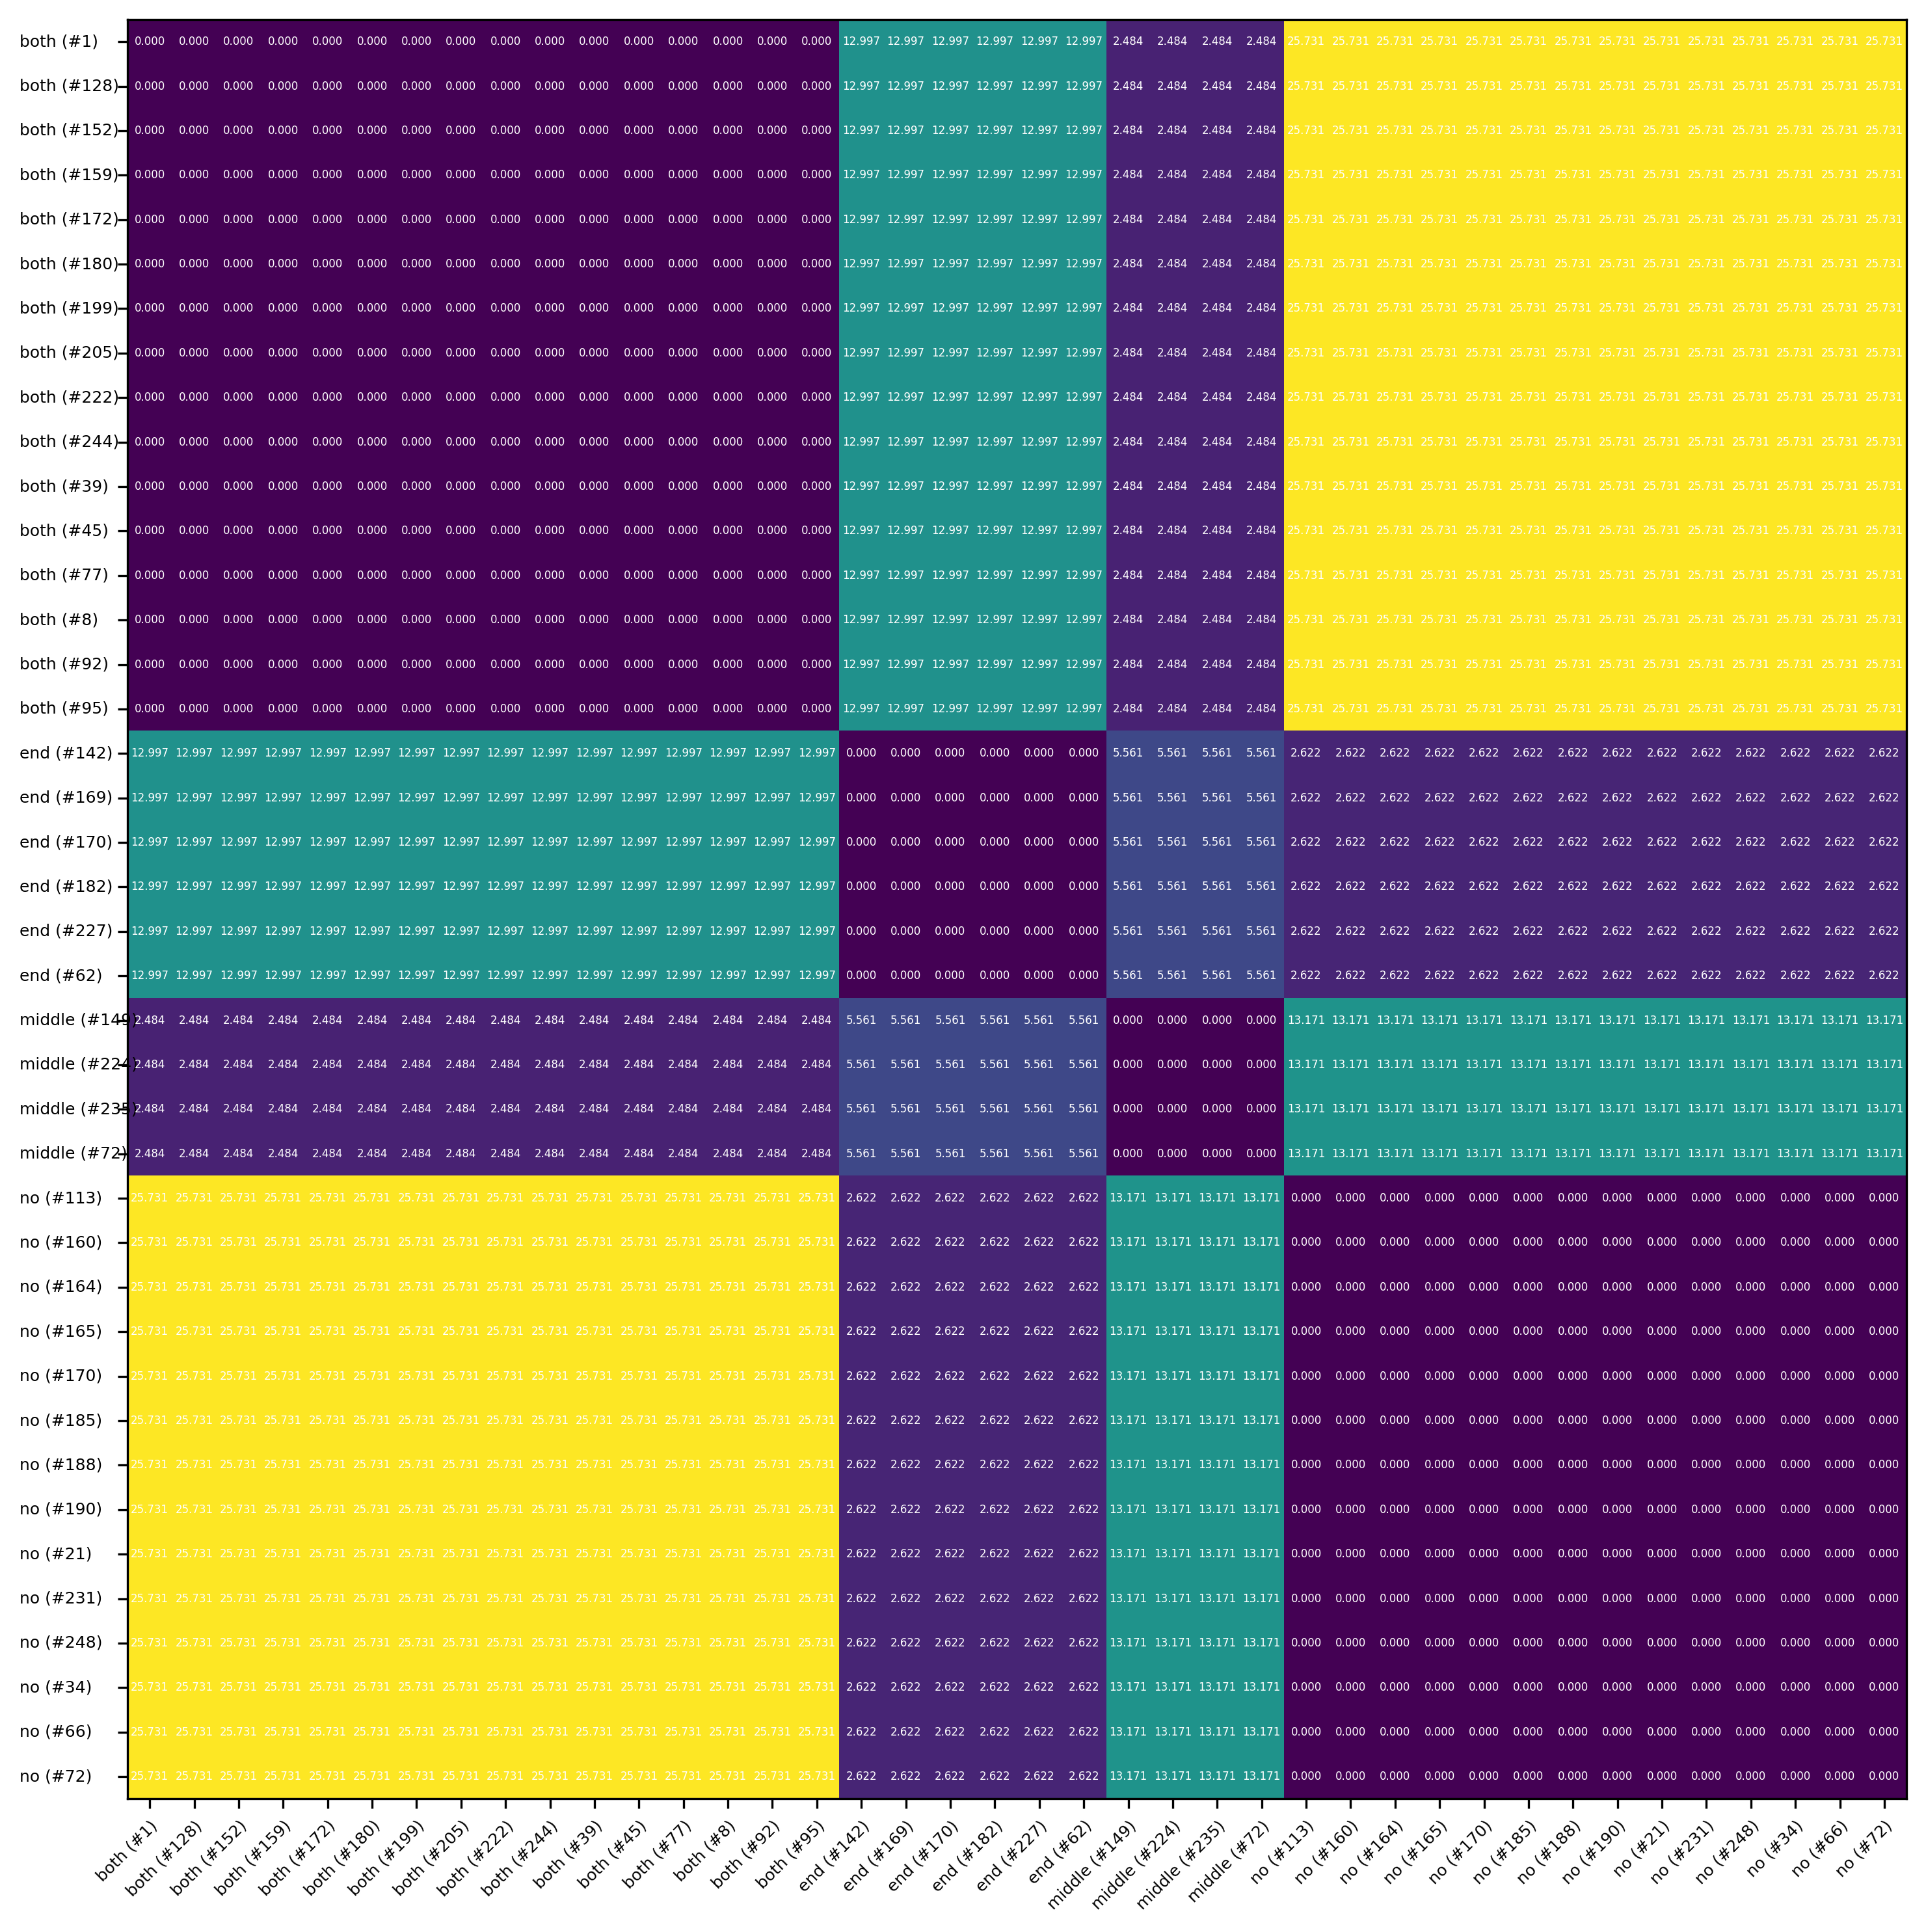

In [34]:
#Display Heat Map
fig, ax = plt.subplots(figsize=(10,10), dpi=300)
im = ax.imshow(id_similarity_matrix)

ax.set_xticks(np.arange(len(test_set._ids)), labels=sorted_id_friendly_list, fontsize="6", ha="right", rotation=45, rotation_mode="anchor")
ax.set_yticks(np.arange(len(test_set._ids)), labels=sorted_id_friendly_list, fontsize="6", ha="left", va="center", position=(-0.05, 0))

for i in range(len(sorted_id_list)):
    for j in range(len(sorted_id_list)):
        text = ax.text(j, i, "{:.3f}".format(id_similarity_matrix[i, j] * 1000), ha="center", va="center", color="w", fontsize="4")

# fig.colorbar(im)
fig.tight_layout()
plt.show()

### Paper Outputs 
*# DSB Modification*

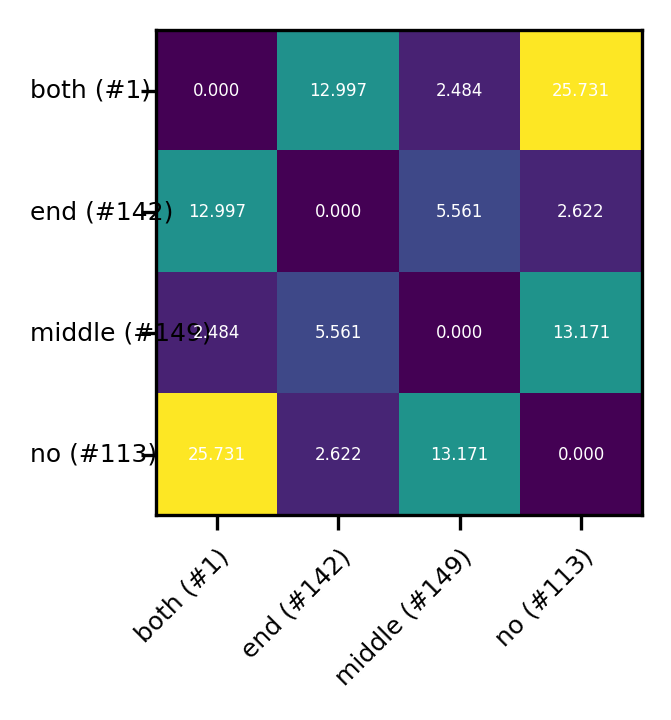

In [35]:
# Get the desired input
desired_inputs = {}
desired_populations = []
for i,input in enumerate(sorted_id_friendly_list):
    parts = input.split(" ")
    if parts[0] not in desired_populations:
        desired_inputs[input] = i
        desired_populations.append(parts[0])

#Get Matrix
desired_id_matrix = np.zeros((len(desired_inputs), len(desired_inputs)))
for i, ikey in enumerate(desired_inputs):
    for j, jkey in enumerate(desired_inputs):
        desired_id_matrix[i][j] = id_similarity_matrix[desired_inputs[ikey]][desired_inputs[jkey]]

#Display Heat Map
fig, ax = plt.subplots(figsize=(2.5,2.5), dpi=300)
im = ax.imshow(desired_id_matrix)

ax.set_xticks(np.arange(len(desired_inputs)), labels=desired_inputs, fontsize="6", ha="right", rotation=45, rotation_mode="anchor")
ax.set_yticks(np.arange(len(desired_inputs)), labels=desired_inputs.keys(), ha="left", va="center", position=(-0.2, 0), fontsize="6")

for i in range(len(desired_inputs)):
    for j in range(len(desired_inputs)):
        text = ax.text(j, i, "{:.3f}".format(desired_id_matrix[i, j] * 1000), ha="center", va="center", color="w", fontsize="4")

# fig.colorbar(im)
fig.tight_layout()
plt.show()